In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Wczytaj obraz w skali szarości
image = cv2.imread("/home/plorenc/Desktop/AiR_ISS/OpenCL/lab4/SobelFilterImage_Input.bmp", cv2.IMREAD_GRAYSCALE)

# Rozmiar kernela
kernel_size = 1  # Musi być liczbą nieparzystą

# Stwórz okrągłą maskę
kernel = np.zeros((kernel_size, kernel_size), dtype=np.uint8)
cv2.circle(kernel, (kernel_size//2, kernel_size//2), kernel_size//2, 1, -1)

# Utwórz pusty obraz do wyniku
filtered_image = np.copy(image)

# Aplikuj medianowy filtr tylko na obszarze maski
for y in range(kernel_size//2, image.shape[0] - kernel_size//2):
    for x in range(kernel_size//2, image.shape[1] - kernel_size//2):
        # Pobierz sąsiedztwo
        region = image[y - kernel_size//2 : y + kernel_size//2 + 1, 
                       x - kernel_size//2 : x + kernel_size//2 + 1]
        
        # Wybierz tylko wartości z maski
        values = region[kernel == 1]
        
        # Zastosuj medianę i przypisz do wyniku
        filtered_image[y, x] = np.median(values)

# Pokaż wynik
plt.imshow(filtered_image, cmap='gray')
plt.axis('off')

KeyboardInterrupt: 

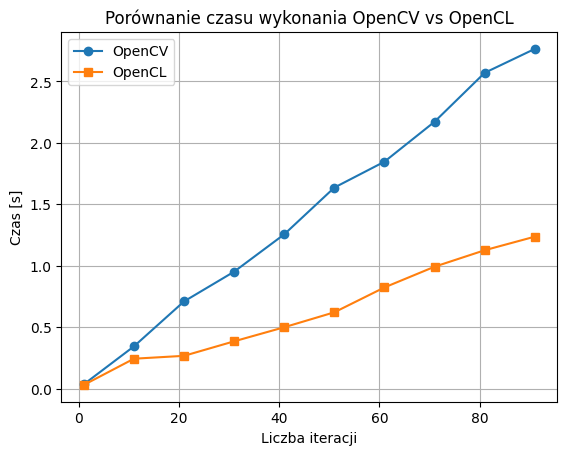

In [14]:
import cv2
import numpy as np
import pyopencl as cl
import time
import matplotlib.pyplot as plt

def load_image(path):
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    return image

# Wczytaj obraz testowy
image = cv2.imread("/home/plorenc/Desktop/AiR_ISS/OpenCL/lab4/SobelFilterImage_Input.bmp", cv2.IMREAD_GRAYSCALE)
imavge = image.resize((4096, 4096))

# **Test OpenCV - Pomiar czasu dla różnych iteracji**
iterations = list(range(1, 101, 10))
opencv_times = []
opencl_times = []

# **OpenCL Setup**
ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)
mf = cl.mem_flags

# Tworzenie buforów dla OpenCL
image_size = image.shape[0] * image.shape[1]
image_input = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=image)
image_output = cl.Buffer(ctx, mf.WRITE_ONLY, image.nbytes)

kernel_code = """
const int kernel_size = 5;
const int kernel_half = kernel_size / 2;

__kernel void erode_filter(__global const uchar *inputImage, __global uchar *outputImage, int width, int height) {
    int x = get_global_id(0);
    int y = get_global_id(1);
    
    if (x < kernel_half || y < kernel_half || x >= width - kernel_half || y >= height - kernel_half) {
        outputImage[y * width + x] = inputImage[y * width + x]; 
        return;
    }

    uchar values[kernel_size * kernel_size];
    int idx = 0;

    for (int dy = -kernel_half; dy <= kernel_half; dy++) {
        for (int dx = -kernel_half; dx <= kernel_half; dx++) {
            values[idx++] = inputImage[(y + dy) * width + (x + dx)];
        }
    }

    // Sortowanie bąbelkowe do wyznaczenia mediany
    for (int i = 0; i < kernel_size * kernel_size - 1; i++) {
        for (int j = 0; j < kernel_size * kernel_size - i - 1; j++) {
            if (values[j] > values[j + 1]) {
                uchar temp = values[j];
                values[j] = values[j + 1];
                values[j + 1] = temp;
            }
        }
    }

    // Przypisanie mediany do wyjścia
    outputImage[y * width + x] = values[kernel_size * kernel_size / 2];
}
"""

# Kompilacja kernela
program = cl.Program(ctx, kernel_code).build()

for num_iter in iterations:
    # **Test OpenCV**
    start_time = time.time()
    for _ in range(num_iter):
        opencv_eroded = cv2.medianBlur(image, 5)
    opencv_times.append(time.time() - start_time)

    # **Test OpenCL**
    start_time = time.time()
    for _ in range(num_iter):
        program.erode_filter(queue, image.shape, None, image_input, image_output, np.int32(image.shape[1]), np.int32(image.shape[0]))
        cl.enqueue_barrier(queue)
    queue.finish()

    output_np = np.empty_like(image)
    cl.enqueue_copy(queue, output_np, image_output).wait()
    opencl_times.append(time.time() - start_time)

# **Wykres czasu wykonania**
plt.plot(iterations, opencv_times, label="OpenCV", marker='o')
plt.plot(iterations, opencl_times, label="OpenCL", marker='s')
plt.xlabel("Liczba iteracji")
plt.ylabel("Czas [s]")
plt.title("Porównanie czasu wykonania OpenCV vs OpenCL")
plt.legend()
plt.grid()
plt.show()


In [21]:
import cv2

# Wczytaj obraz w skali szarości
image = cv2.imread("/home/plorenc/Desktop/AiR_ISS/OpenCL/lab4/SobelFilterImage_Input.bmp", cv2.IMREAD_GRAYSCALE)

# Sprawdź, czy obraz został poprawnie wczytany
if image is None:
    print("Błąd: Nie można załadować obrazu. Sprawdź ścieżkę!")
else:
    # Zmień rozmiar obrazu do 256x256
    image_resized = cv2.resize(image, (4096, 4096))

    # Zapisz nowy obraz
    cv2.imwrite("/home/plorenc/Desktop/AiR_ISS/OpenCL/lab4/Img4096.bmp", image_resized)

    print("Obraz został zapisany jako Img1028.bmp")


Obraz został zapisany jako Img1028.bmp
